In [1]:
import numpy as np
import matplotlib as mpl
import os
import matplotlib.pyplot as plt
import os
import torch
import sys
import time

PATH ='../codes/'
sys.path.insert(1,PATH)
import IAE_CNN_TORCH_Oct2023 as cnn
from general import normalize,normalize4
import matplotlib.cm as cm
cmap = mpl.colormaps.get_cmap("rainbow")
plt.rcParams.update({'font.size': 34})
vcol = ['mediumseagreen','crimson','steelblue','darkmagenta','burlywood','khaki','lightblue','darkseagreen','deepskyblue','forestgreen','gold','indianred','midnightblue','olive','orangered','orchid','red','steelblue']


C:\Users\DP272459\Anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\DP272459\Anaconda3\envs\pytorch\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
C:\Users\DP272459\Anaconda3\envs\pytorch\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Read data

In [2]:

def read_spectrum(fname):
    spec = []
    for line in open(fname, 'r'):
        spec.append(float(line.rstrip()))
    return np.array(spec)


def GetListData(name=0):
    PATH_DATA=os.path.join('../data/Simulation_steel_sphere', RN_NAME[name])
    list_thickness=[]
    list_data=[]

    for file in os.listdir(PATH_DATA):
        if file.endswith(".dat"):
            tmp_file=os.path.join(PATH_DATA, file)
            list_data+=[tmp_file]
    ## list thickness
    ## replace __ = . , (2__0=2.0mm)
    for tmp_file in list_data:
        pos=tmp_file.find("STEEL")
        tmp_thick=tmp_file.replace(tmp_file[:pos+5],"")
        tmp=tmp_thick.replace("mm.dat","")
        if "__" in tmp:
            tmp=tmp.replace("__",".")
        list_thickness+=[float(tmp)]
    ##sort data 
    ind=np.argsort(list_thickness)
    list_thickness=np.sort(list_thickness)
    list_data = [list_data[i] for i in ind]

    return list_data,list_thickness


def GetSpectra(name=0):
    list_data,list_thickness=GetListData(name)
    spec=[]
    for i in range(len(list_data)):
        spec += [read_spectrum(list_data[i])]
    spec=np.array(spec).T
    # cut 20kev 
    # 1024 channels, 1 channel=2kev
    spec = spec[20:2048+20,:]
    spec=spec[0::2,:]+spec[1::2,:]
    ## channel>max channel: value =0
    spec[max_channel_list[name]:,:]=0
    ## Am241 with high thicknesses, spectral signatures are almost absored by attenuation 
    ## X of Am241 for thickness >4 mm = X of 4 mm  
    if name==5:
        spec[:,30:]=spec[:,29:30].dot(np.ones((1,spec.shape[1]-30)))
    
    return spec.T,list_thickness

## Define training test datasets

In [3]:
def get_data_train(spec,nbr_train=70):
    """
    spec: spectra with variability of all radionuclides
    nbr_train: number of training data
    """
    ## when number of training data is very small, have to choose carefully data to train
    ## choose training data with enough spectral signatures at low thicknesses (same distance of thinkness)
    if (nbr_train*0.35>20): # minimum 20 training data, 35% at low thickness
        tmp=np.minimum(20,int(nbr_train*0.3)) ## training data is large (80, 90) -> 30%
    else:
        tmp=int(nbr_train*0.35)
        
    Itrain=np.int_(np.linspace(0,24,tmp))# low thicknesses
    Itrain=np.concatenate((Itrain,np.int_(np.linspace(24,95,nbr_train-tmp+1))[1:]))
    Itest=np.array(list(set(np.arange(96)) - set(Itrain)))
    Xtrain = normalize4(spec_list[Itrain,:,:],opt=norm)
    Xtest = normalize4(spec_list[Itest,:,:],opt=norm)
    AnchorPoints = Xtrain[[0,-1]]## anchor points: position 0 and 95 (1e-6 and 30 mm thickness) 
    return Xtrain,Xtest, AnchorPoints,Itrain,Itest

In [4]:
PATH="Images"# Folder Images
RN_NAME=['Co60', 'Ba133', 'Co57','Cs137','Eu152','Am241','Y88','Bi207','I123','I131','Tc99m','Ga67']
max_channel_list=np.array([800,250,100,400,900,50,1024,800,100,500,100,250])

In [5]:
norm='1'# normalizing norm
spec_list=[]
for name in range((len(RN_NAME))):
    spec,list_thickness=GetSpectra(name)
    spec_list+=[spec]
spec_list=np.swapaxes(spec_list,0,1)
spec_list=np.swapaxes(spec_list,1,2)
spec_list=normalize4(spec_list[:,:,:],opt=norm)

<Figure size 1300x1000 with 0 Axes>

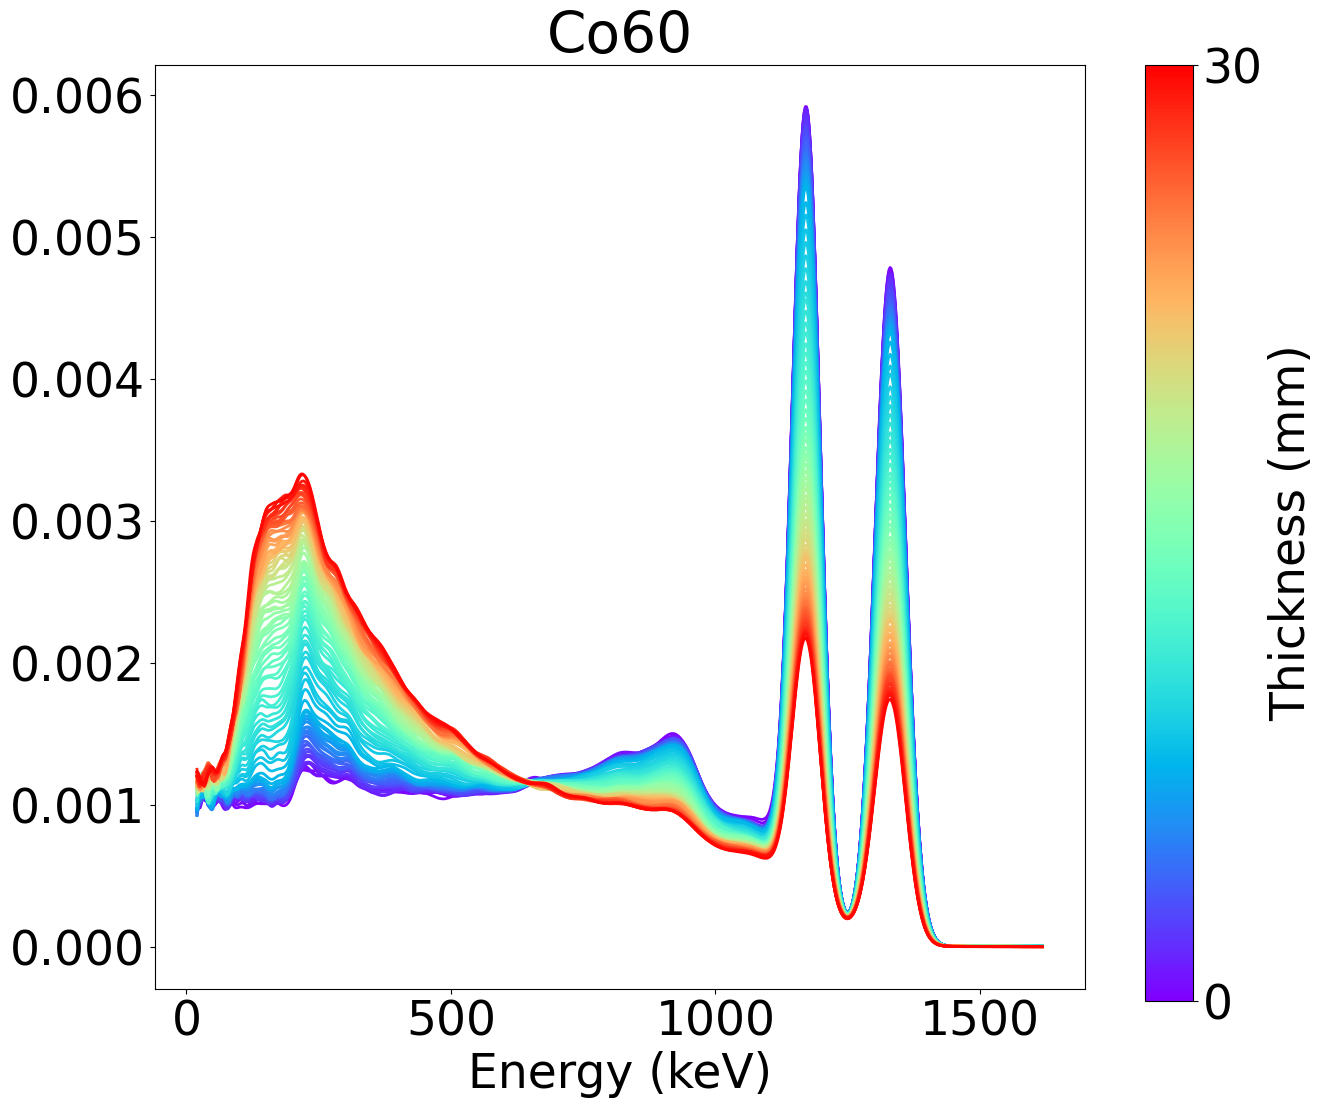

In [6]:
im=plt.figure(figsize=(13,10))
fig, ax = plt.subplots(1, 1, figsize=(12, 12))  # setup the plot

name=0# Co60
start,end, step=0,96,1
tmp=np.arange(start,end,step)
enr=np.arange(max_channel_list[name])*2+20   
for i in range(start,end,step):
    ax.plot(enr,spec_list[i,:max_channel_list[name],name],label= str(list_thickness[i])+ "mm",lw=2,color= cmap((i-start) / (end-start)))
    #plt.legend(fontsize=10)
plt.xlabel('Energy (keV)')
plt.title(RN_NAME[name])
ax2 = fig.add_axes([0.95, 0.1, 0.04, 0.78])
nor = mpl.colors.Normalize(vmin=0,vmax=30)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=nor)
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=nor,
        spacing='proportional', ticks=np.linspace(0,30,2),label='Thickness (mm)'  )

### Define using the pre-trained model or train a new model (joint IAE CNN)

In [7]:
load_pretrained_model=True ##  set false  to train a new IAE model
nbr_train_data=40 # 40 data for training, 56 for test

In [8]:
if load_pretrained_model==False:
    t1=time.time()
    Xtrain,Xtest, AnchorPoints,Itrain,Itest=get_data_train(spec_list,40)
    fsize = np.array([4,4,6,6,6,6,8]).astype('int32')  # Filter size
    fstride = np.array([1,1,2,2,2,2,2]).astype('int32')  # stride
    fnum = np.array([12,12,16,16,16,16,20]).astype('int32') # number of filter
    ## lateral connexion
    rho_latcon = np.array([0.5,0.1,0.05,0.01,0.01,0.005,0.001,0.001,0.0,0.0,0.0,0.0,0.0]).astype('float32')
    ## no lateral connexion (Note: add more one layer in fsize, fstride,fnum  to get almost the same result)
    learning_rate=1e-3
    fname='./Models/cnn_tmp'## name of new model
    niter = 25000
    reg_parameter=1e-3 # parameter of regulisation (mu in paper)
    optim=0 # solver Adam
    noise_level=40 # corrupt the input data with noise, the value of noise_level is SNR (dB)
    GaussNoise=True # Gaussian noise with the same std for each channel (energy)
    LossOpt='log'# mean of log of mse of each radionculide 

    arg_train = cnn.get_train_args(LossOpt=LossOpt,accumulate_grad_batches=2,reg_parameter=reg_parameter,max_epochs=niter,fname=fname,batch_size=36,noise_level=noise_level,learning_rate=learning_rate,Optimizer=optim,verb=True,GaussNoise=GaussNoise)
    arg_IAE = cnn.get_IAE_args(device="cuda",mean_lambda=True,rho_latcon=rho_latcon,anchorpoints = AnchorPoints, nsize_fstride = fstride, nsize_fsize = fsize, nsize_fnum = fnum,simplex=True,nonneg_weights='warm',normalisation=norm)
    out = cnn.training_lightning(Xtrain,arg_IAE=arg_IAE,arg_train=arg_train,Xvalidation=Xtest,checkmodel=False)

    print('time: ',time.time()-t1)

In [9]:
# %load_ext tensorboard
# %tensorboard --logdir=lightning_logs

In [10]:
if load_pretrained_model==True:
    fname='./Models/IAE_CNN_12radio_40data'
model=cnn.load_model(fname)
model.nneg_output=True# spectral signatures are non negative

## CNN IAE Evaluation  

### Rescontruction quality (without noise)

In [11]:
rec=cnn.bsp(spec_list,model,optim=0,lr=0.01)
#rec=cnn.bsp_ctr_fast(spec_list,model,optim=0,lr=0.01)
xrec=rec[0] # Estimated X
xrec=normalize4(xrec,opt=norm)
nmse_list=-20*np.log10(np.linalg.norm(spec_list-xrec,axis=1)/np.linalg.norm(spec_list,axis=1)) # calculate nmse

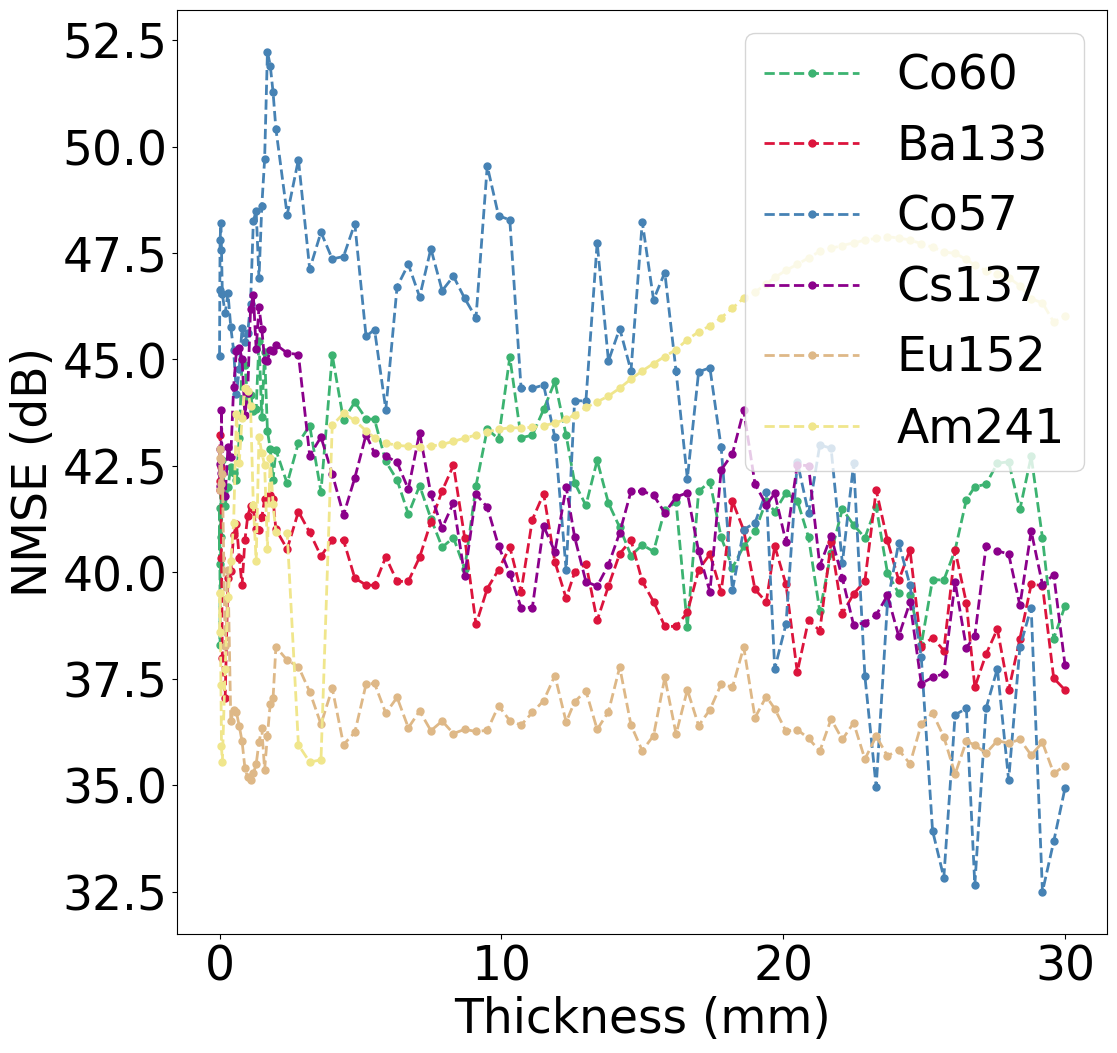

In [12]:
plt.figure(figsize=(12,12))
for r in range(6):
    plt.plot(list_thickness,nmse_list[:,r],color=vcol[r], marker='o', linestyle='dashed',linewidth=2, markersize=5,label=RN_NAME[r])
    plt.legend()
    plt.xlabel('Thickness (mm)')
    plt.ylabel('NMSE (dB)')


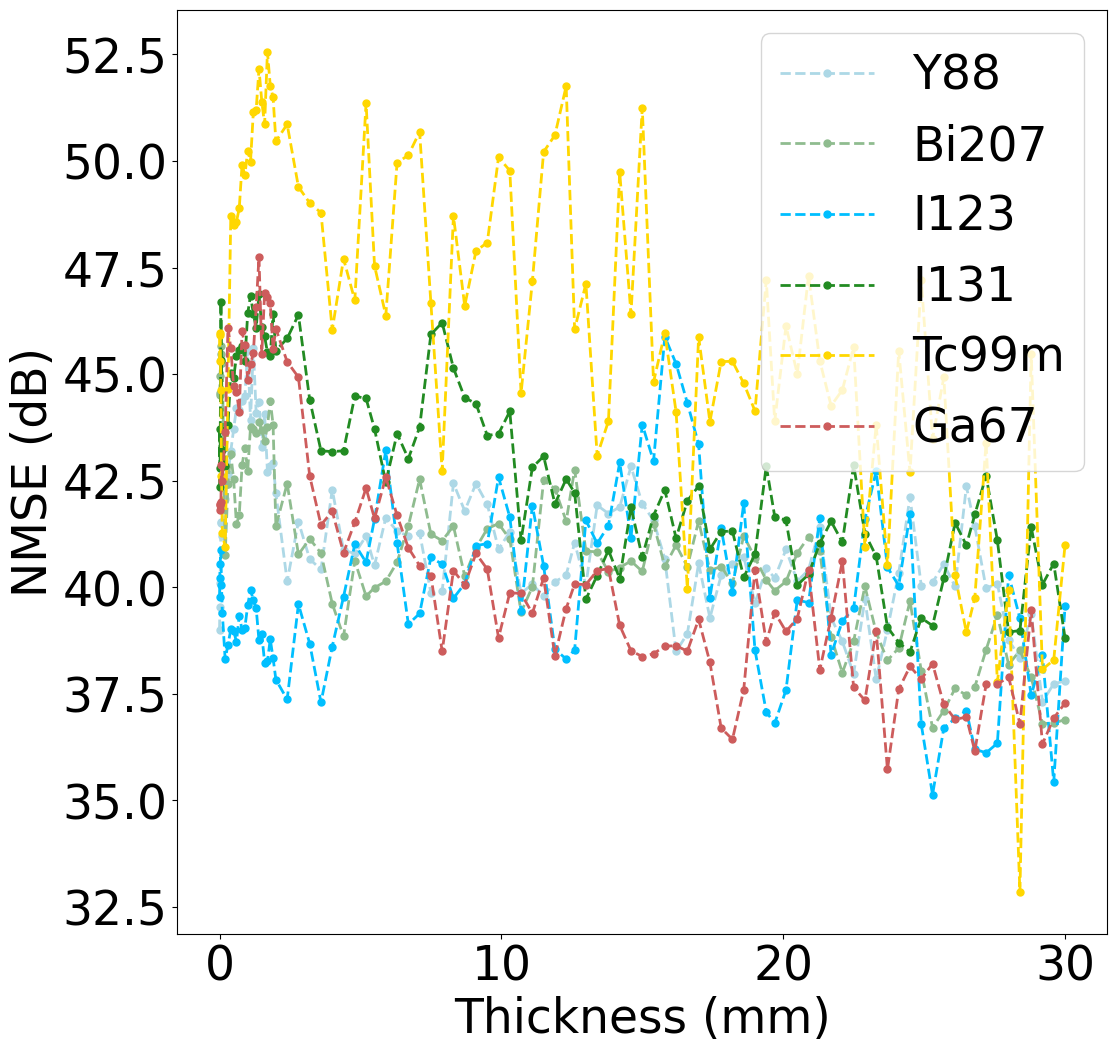

In [13]:
plt.figure(figsize=(12,12))
for r in range(6,12):
    plt.plot(list_thickness,nmse_list[:,r],color=vcol[r], marker='o', linestyle='dashed',linewidth=2, markersize=5,label=RN_NAME[r])
    plt.legend()
    plt.xlabel('Thickness (mm)')
    plt.ylabel('NMSE (dB)')

### Distribution of Lambda 

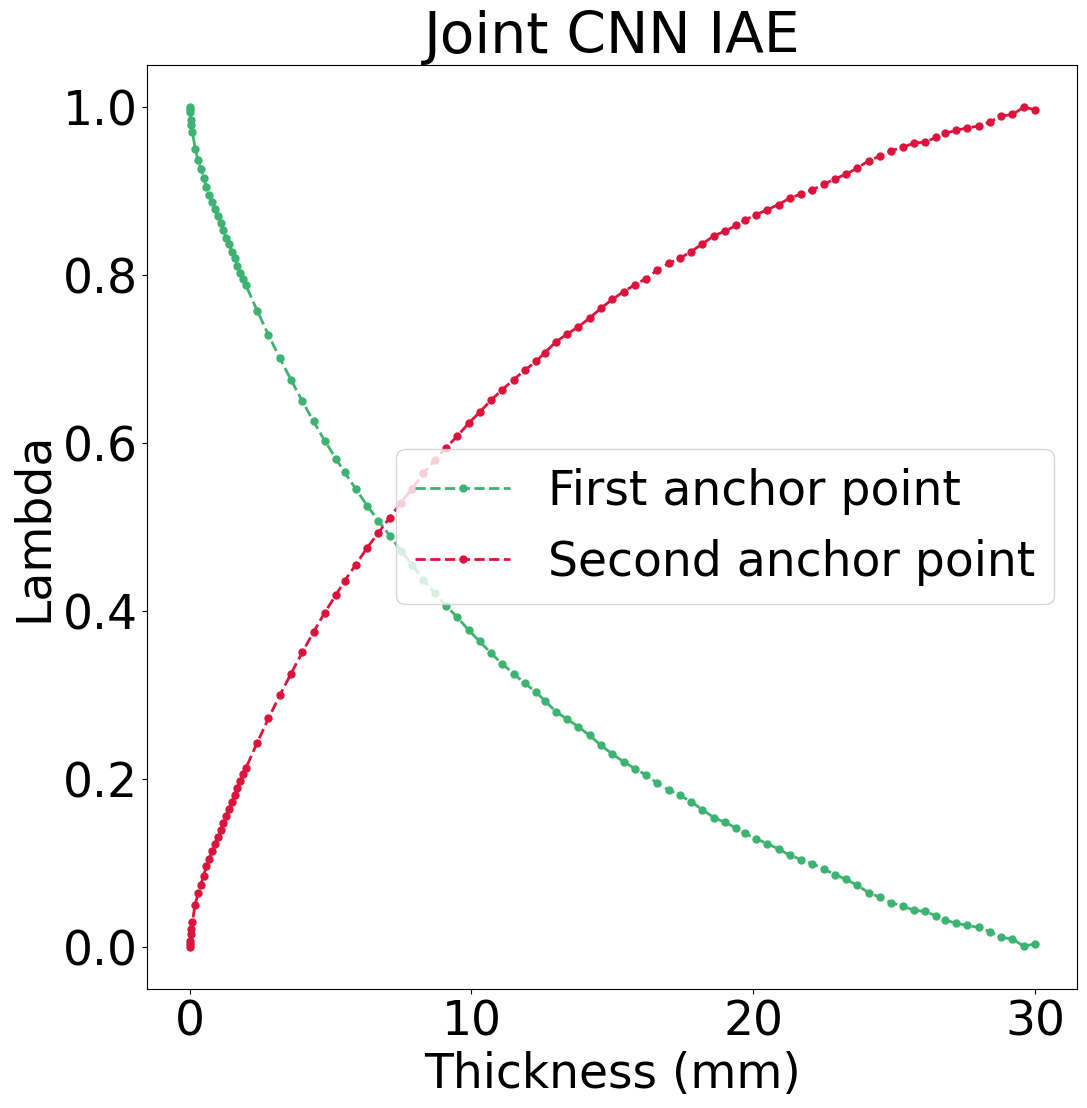

In [14]:
plt.figure(figsize=(12,12))
label_name=['First','Second',]
for j in range(model.anchorpoints.shape[0]):
    plt.plot(list_thickness,rec[1][:,j],color=vcol[j], marker='o', linestyle='dashed',linewidth=2, markersize=5,label=label_name[j]+ ' anchor point')
    
plt.legend()
plt.xlabel('Thickness (mm)')
plt.ylabel('Lambda')
plt.title('Joint CNN IAE')
name_fig= PATH+ 'lambda_cnn_joint'
#plt.savefig(name_fig)

## An example of estimated spectral signature

Text(0.5, 1.0, 'Ba133')

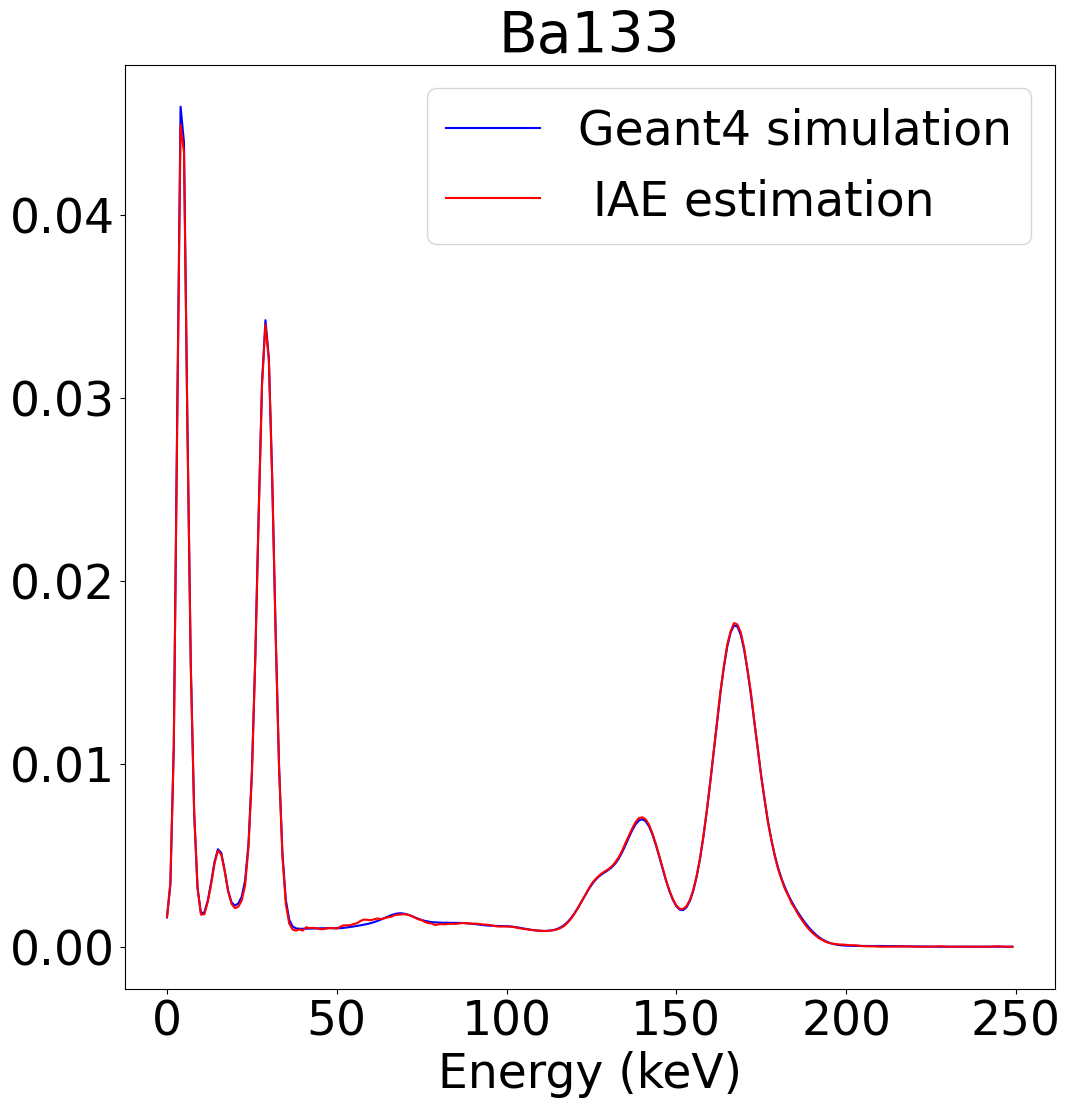

In [15]:
name=1# Ba133
pos=np.argmin(nmse_list[:,name])# index gives the smallest NMSE (the worst estimated X)
plt.figure(figsize=(12,12))

spec=spec_list[pos,:,name]
max_channel=max_channel_list[name]
plt.plot(spec[:max_channel],color='b',label='Geant4 simulation')
plt.plot(xrec[pos,:max_channel,name],color='r',label=' IAE estimation')
plt.xlabel('Energy (keV)')
plt.legend()
plt.title(RN_NAME[name])
